# Text-To-Speech voice cloning

Text-to-speech (TTS) is the process of converting written text into spoken words. The goal is to generate natural-sounding speech, often in multiple languages and using different speaker voices. Some advanced TTS models, such as Bark, MMS, VITS, and SpeechT5, are capable of more than just basic speech. For instance, models like Bark can simulate non-verbal sounds like laughter or crying and even include music.

In this project, we'll focus on fine-tuning SpeechT5. This model is unique because it has been pre-trained on both speech-to-text and text-to-speech tasks, learning shared representations for text and speech. This allows us to use the same model for various tasks after fine-tuning. Additionally, SpeechT5 supports multi-speaker synthesis by using x-vector speaker embeddings, making it ideal for our voice cloning task.



## Install required packages

We'll first install the necessary libraries, including datasets, soundfile, and speechbrain, to prepare our environment. Since some of the features we'll use are cutting-edge, we’ll install the Transformers library directly from GitHub.

In [2]:
!pip install datasets soundfile speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.2/807.2 kB 12.5 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-7yjxxd3c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-7yjxxd3c
  Resolved https://github.com/huggingface/transformers.git to commit 049682a5a63042f087fb45ff128bfe281b2ff98b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.46.0.dev0-py3-none-any.whl size=10025236 sha256=a534661af966e1b1c61ac7963f6ebc63045f6144f969412b0bb441d7562fb2be
  Stored in directory: /tmp/pip-ephem-wheel-cache-geybpsfs/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1


In [4]:
!pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


## Load the model

In [5]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

# Load the pre-trained SpeechT5 model and processor for fine-tuning
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

## Load the dataset

We'll start from the fine-tuned SpeechT5 for English TTS and fine-tune it further for a new language. Here, we will use the VoxPopuli dataset, a large-scale multilingual corpus sourced from 2009-2020 European Parliament event recordings. The dataset contains audio-transcription pairs in 15 European languages. We will use Dutch (nl) for this example.

In [6]:
from datasets import load_dataset, Audio
dataset=load_dataset("facebook/voxpopuli","nl", split="train", trust_remote_code=True)

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

data/n_files.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

asr_train.tsv:   0%|          | 0.00/7.09M [00:00<?, ?B/s]

asr_dev.tsv:   0%|          | 0.00/422k [00:00<?, ?B/s]

asr_test.tsv:   0%|          | 0.00/405k [00:00<?, ?B/s]

train_part_0.tar.gz:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

train_part_1.tar.gz:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

train_part_2.tar.gz:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

train_part_3.tar.gz:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

train_part_4.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

dev_part_0.tar.gz:   0%|          | 0.00/321M [00:00<?, ?B/s]

test_part_0.tar.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

It is essential to set the sampling rate of the audio data to 16 kHz, as required by the SpeechT5 model.

In [7]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Let's check the size of the dataset:

In [8]:
len(dataset)

20968

This should provide us with a sufficient number of examples for fine-tuning.

# Data Analysis, Visualization

In [9]:
%%capture
!pip install matplotlib==3.7.1
!pip install seaborn==0.12.2

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Convert dataset to pandas DataFrame
df = pd.DataFrame(dataset)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


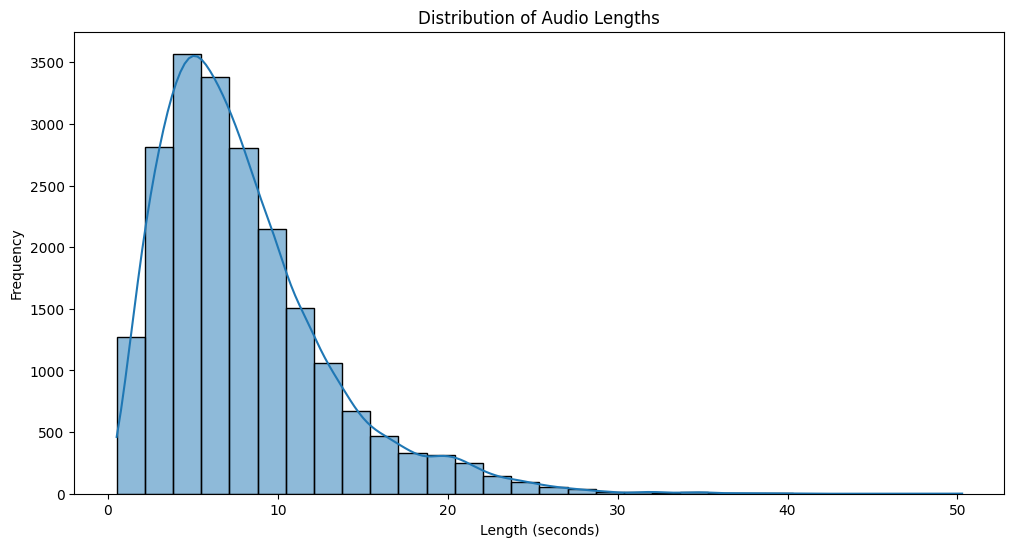

In [12]:
# Calculate audio lengths in seconds
df['audio_length'] = df['audio'].apply(lambda x: x['array'].shape[0] / x['sampling_rate'])

# Plot the distribution of audio lengths
plt.figure(figsize=(12, 6))
sns.histplot(df['audio_length'], bins=30, kde=True)
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length (seconds)')
plt.ylabel('Frequency')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


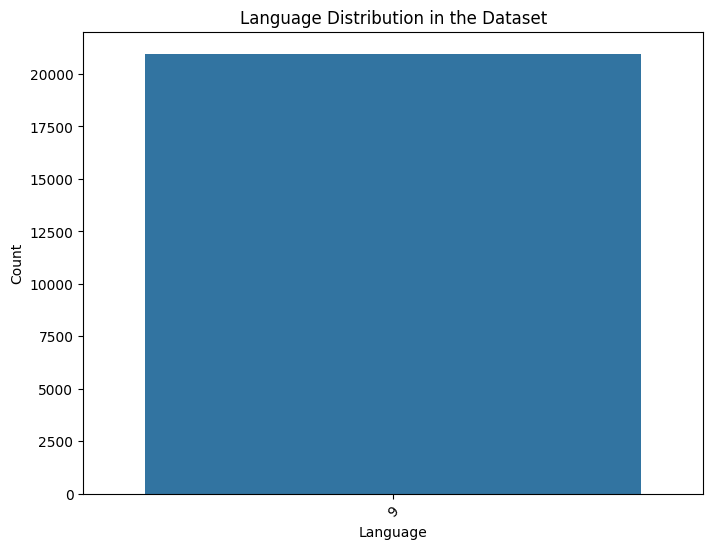

In [13]:
# Count the occurrences of each language
language_counts = df['language'].value_counts()

# Plot the distribution of languages
plt.figure(figsize=(8, 6))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.title('Language Distribution in the Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

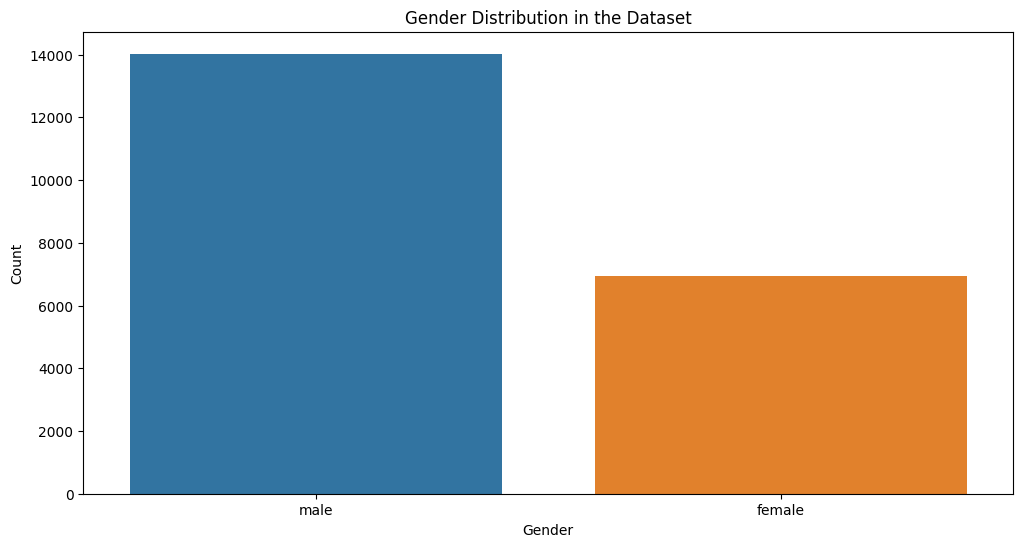

In [14]:
# Count the occurrences of each gender
gender_counts = df['gender'].value_counts()

# Plot the distribution of genders
plt.figure(figsize=(12, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title('Gender Distribution in the Dataset')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

## Clean up the text

The dataset may contain characters unsupported by the SpeechT5 tokenizer. While some diacritics (such as é) are handled, others like à will be mapped to simpler forms. We'll use normalized_text to work around these limitations, especially handling Dutch diacritics.


In [15]:
tokenizer = processor.tokenizer

In [16]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

Characters in the dataset but not in the tokenizer:

In [17]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

We'll define a mapping function to replace unsupported characters:

In [18]:
replacements = [
    ('à', 'a'),
    ('ç', 'c'),
    ('è', 'e'),
    ('ë', 'e'),
    ('í', 'i'),
    ('ï', 'i'),
    ('ö', 'o'),
    ('ü', 'u'),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

## Speakers

We'll define a mapping function to replace unsupported characters:

In [19]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram we can get a sense of how much data there is for each speaker.

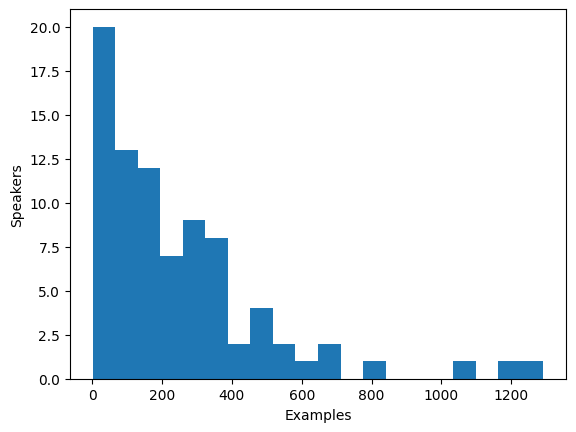

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while arounf ten speakers have more than 500 examples. To improve training effficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

Note that some speakers with few examples may actually have more audio available if the examples are long. However, determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

In [21]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

How many speakers remain?

In [22]:
len(set(dataset["speaker_id"]))

42

And how many examples?

In [23]:
len(dataset)

9973

## Speaker embeddings

We'll use the speechbrain/spkrec-xvect-voxceleb model from SpeechBrain to create speaker embeddings:

In [24]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

/tmp/ipykernel_31/1262525938.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

## Preparing the dataset

Next, we prepare the dataset by tokenizing the input text and converting the audio into a log-mel spectrogram. Speaker embeddings are also added.

In [25]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Testing the process on a single example:


In [26]:
processed_example = prepare_dataset(dataset[0])

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [27]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [28]:
tokenizer.decode(processed_example["input_ids"])

'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.</s>'

Speaker embeddings should be a 512-element vector:

In [29]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

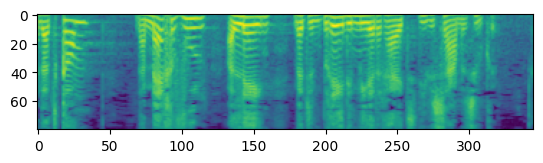

In [30]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [31]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [32]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

In [33]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

Finally, we process the entire dataset:

In [34]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/9973 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


To prevent issues with long inputs, we remove examples with more than 200 tokens:

In [35]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

How many examples are left?

In [36]:
len(dataset)

8259

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [37]:
dataset = dataset.train_test_split(test_size=0.1)

What does the dataset look like now?

In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 7433
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 826
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [39]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the decoder processes the target sequence by taking every other time step, effectively reducing its length by half. This means the decoder predicts a sequence that is twice as long. To ensure smooth processing, the data collator rounds the maximum batch length down to the nearest even number, since the original target sequence might have an odd length.

In [40]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [41]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [42]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 167]),
 'attention_mask': torch.Size([3, 167]),
 'labels': torch.Size([3, 668, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

Upload the model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. 

In [47]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [44]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [45]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [48]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

/tmp/ipykernel_31/4196592502.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
max_steps is given, it will override any value given in num_train_epochs


Training can take several hours, depending on your GPU or the one provided by Google Colab. You might encounter a CUDA "out-of-memory" error when you start training. If that happens, try reducing the per_device_train_batch_size by half and increasing the gradient_accumulation_steps accordingly.

In [49]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
1000,1.041900,0.474858
2000,0.997800,0.464379
3000,0.982200,0.458089
4000,0.986400,0.456360


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2816: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/opt/conda/lib/python3.10

TrainOutput(global_step=4000, training_loss=1.0470435147285462, metrics={'train_runtime': 10205.9455, 'train_samples_per_second': 12.542, 'train_steps_per_second': 0.392, 'total_flos': 2.019492369922817e+16, 'train_loss': 1.0470435147285462, 'epoch': 17.204301075268816})

In [68]:
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "VoxPopuli",  
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "SpeechT5 TTS Dutch",  
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [71]:
from huggingface_hub import notebook_login

In [72]:
notebook_login()

In [73]:
trainer.push_to_hub("Molkaatb/speecht5_tts_voxpopuli_nl")

CommitInfo(commit_url='https://huggingface.co/Molkaatb/speecht5_tts_voxpopuli_nl/commit/eadfa4d336aa8664630f33717859147c21f35297', commit_message='Molkaatb/speecht5_tts_voxpopuli_nl', commit_description='', oid='eadfa4d336aa8664630f33717859147c21f35297', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Molkaatb/speecht5_tts_voxpopuli_nl', endpoint='https://huggingface.co', repo_type='model', repo_id='Molkaatb/speecht5_tts_voxpopuli_nl'), pr_revision=None, pr_num=None)

## Evaluate

After training is complete, we can use the model to synthesize speech! Since the Colab notebook may have been interrupted before training finished, we'll load the trained model from the Hugging Face Hub. This is why it’s beneficial to set push_to_hub=True during training.

In [74]:
model = SpeechT5ForTextToSpeech.from_pretrained("Molkaatb/speecht5_tts_voxpopuli_nl")

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Next, we need a speaker embedding. We can easily take one from the test set.



In [75]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Now, let's define some input text and tokenize it.



In [111]:
text = "Hallo allemaal! Dit spraakmodel presteert goed!"

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [112]:
inputs = processor(text=text, return_tensors="pt")

We can then instruct the model to generate a spectrogram from our input text.



In [113]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

Let's visualize the generated spectrogram.



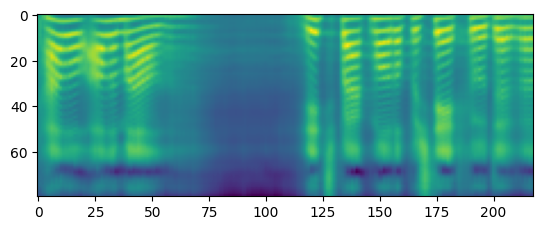

In [114]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, we'll convert the spectrogram into sound using the vocoder.



In [115]:
with torch.no_grad():
    speech = vocoder(spectrogram)

You can play the synthesized speech directly in the notebook:



In [116]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

And if you’d like to save the output as a WAV file, you can do so like this:



In [117]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

# Conclusion
In this notebook, we successfully fine-tuned the SpeechT5 model for Dutch text-to-speech synthesis using the VoxPopuli dataset. Throughout the training process, we monitored performance metrics to ensure that the model was learning effectively.

After completing the training, we evaluated the model's ability to synthesize natural-sounding speech from various input texts. The results demonstrated that our fine-tuned model can produce high-quality audio that closely resembles human speech, making it suitable for applications in voice assistants, audiobooks, and other areas requiring text-to-speech capabilities.